<a href="https://colab.research.google.com/github/EddyGiusepe/Studying_Transfer_Learning/blob/main/Transfer_Learning_with_Pytorch_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 align="center">Transfer Learning com Pytorch</h2>

Data Scientist.: Dr.Eddy Giusepe Chirinos Isidro

Este script foi baseado no maravilhoso tutorial de [Pepe Cantoral, PhD](https://www.youtube.com/watch?v=Y_WAXe4LprY).


Contextualização:

Este script explica como utilizar TRANSFER LEARNING com Pytorch. Asim, podemos fazer uso de um modelo de Deep Learning PRE-TREINADO em ``ImageNet`` ou outra base de Dados com informação abundante e fazer uso desta capacidade de abstração para treinar nosso modelo e obter bons resultados ainda com Dados e recursos computacionais limitados. Aqui usaremos ``ResNet18`` para extrair características principais de nossos Dados.  


Mais um link de estudo:

* [Pytorch: Transfer Learning](https://www.youtube.com/watch?v=K0lWSB2QoIQ)


* [Transfer Learning com o Bert em PT-BR](https://www.youtube.com/watch?v=kRyOAapLpIo&t=350s)

# Treinamento: Sem Transfer Learning

In [1]:
# Importamos nossas bibliotecas

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader # Converte o Dataset num objeto iterável
from torch.utils.data import sampler
import torchvision.datasets as datasets # Base de Dados pre-carregadas (MNIST, CIFAR, etc)
import torchvision.transforms as T
from torchvision import models

import matplotlib.pyplot as plt


In [2]:
# Descarregamos nossos Dados (Dados do CIFAR 10)

DATA_PATH = '/content/drive/MyDrive/5_Scripts_in_Python_Eddy/2_Transfer_Learning'
NUM_TRAIN = 45000
MINIBATCH_SIZE = 64


transform_imagenet = T.Compose([
                T.Resize(224),
                T.ToTensor(),
                T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])

transform_cifar = T.Compose([
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261]) # [0.491, 0.482, 0.447] --> R, G, B, respectivamente
            ])


# Training set loader
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_cifar)

train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# Validation set loader
cifar10_val = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                           transform=transform_cifar)

val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(cifar10_val))))

# Testing set loader
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True, 
                            transform=transform_cifar)

test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Usar GPU

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [4]:
# Aqui mostramos o como podemos iterar os valores do Data loader.

for i, (x, y) in enumerate(val_loader):
    print(i, x.shape, y.shape)

0 torch.Size([64, 3, 32, 32]) torch.Size([64])
1 torch.Size([64, 3, 32, 32]) torch.Size([64])
2 torch.Size([64, 3, 32, 32]) torch.Size([64])
3 torch.Size([64, 3, 32, 32]) torch.Size([64])
4 torch.Size([64, 3, 32, 32]) torch.Size([64])
5 torch.Size([64, 3, 32, 32]) torch.Size([64])
6 torch.Size([64, 3, 32, 32]) torch.Size([64])
7 torch.Size([64, 3, 32, 32]) torch.Size([64])
8 torch.Size([64, 3, 32, 32]) torch.Size([64])
9 torch.Size([64, 3, 32, 32]) torch.Size([64])
10 torch.Size([64, 3, 32, 32]) torch.Size([64])
11 torch.Size([64, 3, 32, 32]) torch.Size([64])
12 torch.Size([64, 3, 32, 32]) torch.Size([64])
13 torch.Size([64, 3, 32, 32]) torch.Size([64])
14 torch.Size([64, 3, 32, 32]) torch.Size([64])
15 torch.Size([64, 3, 32, 32]) torch.Size([64])
16 torch.Size([64, 3, 32, 32]) torch.Size([64])
17 torch.Size([64, 3, 32, 32]) torch.Size([64])
18 torch.Size([64, 3, 32, 32]) torch.Size([64])
19 torch.Size([64, 3, 32, 32]) torch.Size([64])
20 torch.Size([64, 3, 32, 32]) torch.Size([64])
21

A imagem mostrada representa um: Frog



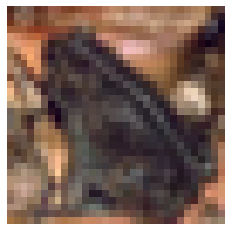

In [5]:
# Mostramos as imagens
# Como são imagens muito pequenas, elas se vem muito PIXELEADAS

classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer','Dog', 'Frog', 'Horse', 'Ship', 'Truck']

def plot_figure(image):
    plt.imshow(image.permute(1,2,0))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'A imagem mostrada representa um: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
print("")
plot_figure(image)


In [6]:
# Aqui se define a função para a Accuracy

def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)
        return float(num_correct)/num_total  

In [7]:
# Loop de Treinamento

def train(model, optimiser, epochs=100):
#     def train(model, optimiser, scheduler = None, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(train_loader):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)

            cost = F.cross_entropy(input= scores, target=yi)
        
            optimiser.zero_grad()           
            cost.backward()
            optimiser.step()           
            
        acc = accuracy(model, val_loader)
        if epoch%5 == 0:
          print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {acc},')
        #scheduler.step()

In [8]:
# Aqui vamos a implementar um modelo Linear (modificar a última capa a REDE)

hidden1 = 256 
hidden = 256
lr = 5e-4
epochs = 20
model1 = nn.Sequential(nn.Flatten(), 
                        nn.Linear(in_features=32*32*3, out_features=hidden1), nn.ReLU(),
                        nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                        nn.Linear(in_features=hidden, out_features=10))

#model1 = nn.Sequential(model_aux,
#                       nn.Flatten(), 
#                       nn.Linear(in_features=512, out_features= 10, bias= True))
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999))


train(model1, optimiser, epochs)

Epoch: 0, costo: 0.9286417365074158, accuracy: 0.4808,
Epoch: 5, costo: 0.6184097528457642, accuracy: 0.5374,
Epoch: 10, costo: 0.8472197651863098, accuracy: 0.5404,
Epoch: 15, costo: 0.16244854032993317, accuracy: 0.529,


In [9]:
# Calculamos Accuracy com os Dados de teste (test_loader):

accuracy(model1, test_loader)

0.5251

# Treinamento: Com Transfer Learning

In [10]:
# Importamos nossas bibliotecas

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader # Converte o Dataset num objeto iterável
from torch.utils.data import sampler
import torchvision.datasets as datasets # Base de Dados pre-carregadas (MNIST, CIFAR, etc)
import torchvision.transforms as T
from torchvision import models

import matplotlib.pyplot as plt

In [11]:
DATA_PATH = '/media/josh/MyData2SSD/Databases/cifar-10-batches-py'
NUM_TRAIN = 45000
MINIBATCH_SIZE = 64
transform_imagenet = T.Compose([
                T.Resize(224),
                T.ToTensor(),
                T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])

transform_cifar = T.Compose([
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
            ])

# Training set loader
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_imagenet)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# Validation set loader
cifar10_val = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                           transform=transform_imagenet)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(cifar10_val))))

# Testing set loader
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True, 
                            transform=transform_imagenet)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /media/josh/MyData2SSD/Databases/cifar-10-batches-py/cifar-10-python.tar.gz to /media/josh/MyData2SSD/Databases/cifar-10-batches-py
Files already downloaded and verified
Files already downloaded and verified


In [12]:
# Quantidade de Dados 

print(len(val_loader))
print(len(cifar10_test))

79
10000


In [13]:
for i, (x, y) in enumerate(val_loader):
    print(i, x.shape, y.shape)

0 torch.Size([64, 3, 224, 224]) torch.Size([64])
1 torch.Size([64, 3, 224, 224]) torch.Size([64])
2 torch.Size([64, 3, 224, 224]) torch.Size([64])
3 torch.Size([64, 3, 224, 224]) torch.Size([64])
4 torch.Size([64, 3, 224, 224]) torch.Size([64])
5 torch.Size([64, 3, 224, 224]) torch.Size([64])
6 torch.Size([64, 3, 224, 224]) torch.Size([64])
7 torch.Size([64, 3, 224, 224]) torch.Size([64])
8 torch.Size([64, 3, 224, 224]) torch.Size([64])
9 torch.Size([64, 3, 224, 224]) torch.Size([64])
10 torch.Size([64, 3, 224, 224]) torch.Size([64])
11 torch.Size([64, 3, 224, 224]) torch.Size([64])
12 torch.Size([64, 3, 224, 224]) torch.Size([64])
13 torch.Size([64, 3, 224, 224]) torch.Size([64])
14 torch.Size([64, 3, 224, 224]) torch.Size([64])
15 torch.Size([64, 3, 224, 224]) torch.Size([64])
16 torch.Size([64, 3, 224, 224]) torch.Size([64])
17 torch.Size([64, 3, 224, 224]) torch.Size([64])
18 torch.Size([64, 3, 224, 224]) torch.Size([64])
19 torch.Size([64, 3, 224, 224]) torch.Size([64])
20 torch.S

In [14]:
# Usar GPU 

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


La imagen muestreada representa un: Horse



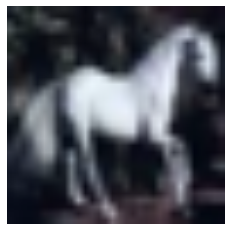

In [15]:
# Visualizando algumas imagens

classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer','Dog', 'Frog', 'Horse', 'Ship', 'Truck']

def plot_figure(image):
    plt.imshow(image.permute(1,2,0))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
print("")
plot_figure(image)

In [16]:
# Aqui definimos o calcula de Accuracy

def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)
        return float(num_correct)/num_total   

## <font color="orange">Carregamos o Modelo PRE-TREINADO</font>

* [TORCHVISION.MODELS](https://pytorch.org/vision/0.8/models.html)

* [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)

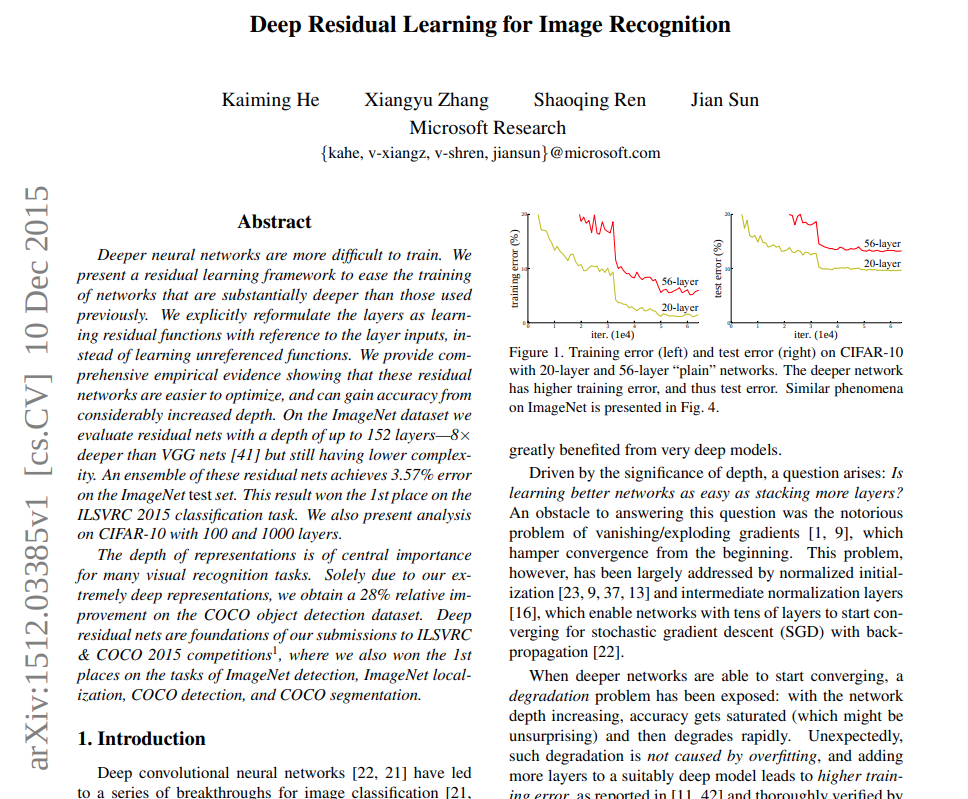

In [17]:
# Carregando o modelo pre-treinado

model_resnet18 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [18]:
# Explorando o modelo

for i, w in enumerate(model_resnet18.parameters()):
    print(i, w.shape, w.requires_grad) # fazer este parâmetro "w.requires_grad" igual a falso para congelar todos blocos e deixar so a última capa para treinar

    

0 torch.Size([64, 3, 7, 7]) True
1 torch.Size([64]) True
2 torch.Size([64]) True
3 torch.Size([64, 64, 3, 3]) True
4 torch.Size([64]) True
5 torch.Size([64]) True
6 torch.Size([64, 64, 3, 3]) True
7 torch.Size([64]) True
8 torch.Size([64]) True
9 torch.Size([64, 64, 3, 3]) True
10 torch.Size([64]) True
11 torch.Size([64]) True
12 torch.Size([64, 64, 3, 3]) True
13 torch.Size([64]) True
14 torch.Size([64]) True
15 torch.Size([128, 64, 3, 3]) True
16 torch.Size([128]) True
17 torch.Size([128]) True
18 torch.Size([128, 128, 3, 3]) True
19 torch.Size([128]) True
20 torch.Size([128]) True
21 torch.Size([128, 64, 1, 1]) True
22 torch.Size([128]) True
23 torch.Size([128]) True
24 torch.Size([128, 128, 3, 3]) True
25 torch.Size([128]) True
26 torch.Size([128]) True
27 torch.Size([128, 128, 3, 3]) True
28 torch.Size([128]) True
29 torch.Size([128]) True
30 torch.Size([256, 128, 3, 3]) True
31 torch.Size([256]) True
32 torch.Size([256]) True
33 torch.Size([256, 256, 3, 3]) True
34 torch.Size([25

In [19]:
# Visualizamos as camadas do nosso Modelo

model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Ajustamos nosso Modelo

In [21]:
model_aux = nn.Sequential(*list(model_resnet18.children())) 
# Aqui recebe as camadas anteriores da Rede, como uma "lista desempacotada"

model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

<font color="orange">A seguir pegaremos todas as camadas menos a última camada.</font>

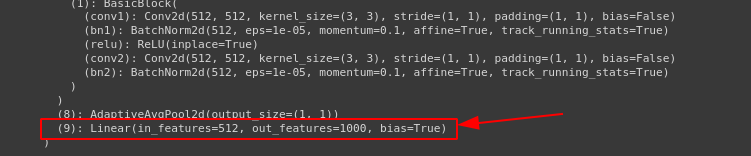

In [22]:
# Todas as camadas (ou capas) menos a última camada

model_aux = nn.Sequential(*list(model_resnet18.children())[:-1])

In [23]:
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [24]:
for i, parameter in enumerate(model_aux.parameters()):
    parameter.requires_grad = False

# Lembrando que colocar = False, significa que essas capas não vão ser treináveis    

In [25]:
# Podemos visualizar essa mudança

for i, parameter in enumerate(model_aux.parameters()):
    print(i, parameter.requires_grad)
    

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False


## Loop de Treinamento

In [26]:
def train(model, optimiser, epochs=100):
#     def train(model, optimiser, scheduler = None, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(train_loader):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)

            cost = F.cross_entropy(input= scores, target=yi)
        
            optimiser.zero_grad()           
            cost.backward()
            optimiser.step()           
            
        acc = accuracy(model, val_loader)
#         if epoch%5 == 0:     
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {acc},')
#         scheduler.step()

In [27]:
hidden1 = 256 
hidden = 256
lr = 5e-4
epochs = 5
# model1 = nn.Sequential(nn.Flatten(),
#                        nn.Linear(in_features=32*32*3, out_features=hidden1), nn.ReLU(),
#                        nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
#                        nn.Linear(in_features=hidden, out_features=10))

# Como observamos, estamos passando todas as capas do modelo pre-treinado (ResNet). Isso está no objeto model_aux
model1 = nn.Sequential(model_aux,
                       nn.Flatten(), 
                       nn.Linear(in_features=512, out_features= 10, bias= True))
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999))

# train(model1, optimiser, epochs)

In [28]:
# Agora podemos observar que o model1 tem todas as capas (ou camadas) do modelo pre-treinado ResNet18 mais nossa CAMADA 
# modificada para nossa tarefa

model1

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

<font color="orange">print da CAMADA modificada (ou adicionada)</font>:

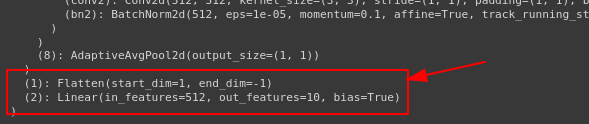

In [29]:
train(model1, optimiser, epochs)


Epoch: 0, costo: 0.9383119344711304, accuracy: 0.7728,
Epoch: 1, costo: 1.095445156097412, accuracy: 0.791,
Epoch: 2, costo: 0.3609717786312103, accuracy: 0.7996,
Epoch: 3, costo: 0.9874261021614075, accuracy: 0.8036,
Epoch: 4, costo: 1.6635770797729492, accuracy: 0.8056,


In [30]:

accuracy(model1, test_loader)


0.8051